# Expand reader group coverage
In prior analysis, we have seen that some reader groups have poor coverage, specifically expertise and demographics.

Let's use the prior author data to expand this coverage.

### Load data

In [1]:
import pandas as pd
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import load_all_author_data
author_data_dir = '../../data/reddit_data/author_data/'
usecols = ['author', 'subreddit', 'created_utc', 'id']
author_data = load_all_author_data(author_data_dir, usecols=usecols)
print(author_data.loc[:, 'author'].nunique())

  3%|▎         | 7043/204619 [03:55<41:21, 79.64it/s]   

skipping file ../../data/reddit_data/author_data/OJnToothpaste_comments.gz because error Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.



 13%|█▎        | 26710/204619 [23:49<1:04:26, 46.02it/s] 

skipping file ../../data/reddit_data/author_data/papercut_eyelid_comments.gz because error Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.



 17%|█▋        | 34126/204619 [30:48<3:44:05, 12.68it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 28%|██▊       | 56942/204619 [52:19<4:53:10,  8.40it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 42%|████▏     | 86740/204619 [1:13:33<1:11:55, 27.31it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable


In [2]:
## limit to actual question askers
question_comment_data = pd.read_csv('../../data/reddit_data/advice_subreddit_no_filter_comment_question_data.gz', sep='\t', compression='gzip', usecols=['author', 'parent_id', 'subreddit', 'created_utc'])

In [22]:
## get date info
from datetime import datetime, timedelta
from monthdelta import monthdelta
import re
# num_matcher = re.compile('\d+\.\d')
# author_data = author_data.assign(**{
#     'date' : author_data.loc[:, 'created_utc'].apply(lambda x: datetime.fromtimestamp(int(float(x))) if (type(x) is str and num_matcher.match(x) is not None) else x),
# })
# question_comment_data = question_comment_data.assign(**{
#     'date' : question_comment_data.loc[:, 'created_utc'].apply(lambda x: datetime.fromtimestamp(int(float(x)))),
# })
## convert to date-day bins
from math import ceil
import numpy as np
start_year, end_year = 2018, 2019
start_month, end_month = 1, 12
bin_month_width = 6
months_per_year = 12
date_bin_count = int(ceil(((end_year - start_year + 1) * months_per_year) / bin_month_width))
start_date = datetime(year=start_year, month=1, day=1)
date_bins = [start_date + monthdelta(bin_month_width*i) for i in range(date_bin_count)]
date_bins = np.array(list(map(lambda x: x.timestamp(), date_bins)))
from data_helpers import assign_date_bin
author_data = author_data.assign(**{
    'date_day_bin' : author_data.loc[:, 'date'].apply(lambda x: assign_date_bin(x, date_bins) if (type(x) is float and not np.isnan(x)) else None),
})
question_comment_data = question_comment_data.assign(**{
    'date_day_bin' : question_comment_data.loc[:, 'date'].apply(lambda x: assign_date_bin(x.timestamp(), date_bins))
})

In [23]:
author_data.loc[:, 'date_day_bin'].unique()

array([datetime.datetime(2019, 7, 1, 0, 0),
       datetime.datetime(2019, 1, 1, 0, 0),
       datetime.datetime(2018, 7, 1, 0, 0),
       datetime.datetime(2018, 1, 1, 0, 0), -1, None], dtype=object)

## Expand expertise
Let's expand the definition of "expert" by counting the prior posts in topic-relevant subreddits.

Author $a$ posts a question in subreddit $s$.
1. $a$ is an "expert" if at least 90% of their prior posts are in subreddit $s$.
2. $a$ is an "expert" if at least 90% of their prior posts are in subreddits $\mathcal{S}_{t}$, i.e. $s$ or one of its top-k neighbors at time $t$.

In [53]:
## connect authors with original question time + subreddit info
question_comment_data.rename(columns={'subreddit' : 'question_subreddit', 'date_day_bin' : 'question_date_day_bin'}, inplace=True)
author_question_data = pd.merge(author_data, question_comment_data.loc[:, ['author', 'question_subreddit', 'question_date_day_bin']], on='author', how='right')
# fix data type
author_question_data = author_question_data.assign(**{
    'question_date_day_bin' : pd.Series(author_question_data.loc[:, 'question_date_day_bin'].values, dtype='object')
})
# remove null data
author_question_data = author_question_data[author_question_data.loc[:, 'date_day_bin'].apply(lambda x: type(x) is datetime)]

In [39]:
print(author_question_data.shape[0])
display(author_question_data.head())

69616031


,author,subreddit,created_utc,id,date,date_day_bin,question_subreddit,question_date_day_bin
0,DaveAlot,ultrawidemasterrace,1617058469.0,gsqofc7,1617058469.0,2019-07-01 00:00:00,personalfinance,2018-01-01 00:00:00
1,DaveAlot,ultrawidemasterrace,1615528553.0,gqnvkp0,1615528553.0,2019-07-01 00:00:00,personalfinance,2018-01-01 00:00:00
2,DaveAlot,ultrawidemasterrace,1614292110.0,gorg61l,1614292110.0,2019-07-01 00:00:00,personalfinance,2018-01-01 00:00:00
3,DaveAlot,ultrawidemasterrace,1614219096.0,gonosj2,1614219096.0,2019-07-01 00:00:00,personalfinance,2018-01-01 00:00:00
4,DaveAlot,tax,1612253656.0,glpizlx,1612253656.0,2019-07-01 00:00:00,personalfinance,2018-01-01 00:00:00


In [112]:
## get "expert" distribution
# get all posts written before question date
# compute % posted in question subreddit UGH
from tqdm import tqdm
tqdm.pandas()
def get_subreddit_pct_per_author_per_date(data, start_date):
#     print(f'data = \n{data.head()}')
#     print(f'N = {data.shape[0]}')
#     print(f'subreddit counts {data.loc[:, "subreddit"].value_counts()}')
    data.drop_duplicates('id', inplace=True)
    valid_data = data[data.loc[:, 'date_day_bin'] <= start_date]
    subreddit = data.loc[:, 'question_subreddit'].iloc[0]
    subreddit_pct = (data.loc[:, 'subreddit']==subreddit).sum() / data.shape[0]
    return subreddit_pct

In [133]:
from tqdm import tqdm
author_subreddit_counts = []
for subreddit_i, data_i in author_question_data.groupby(['question_subreddit']):
    print(f'**** processing data from subreddit={subreddit_i} ****')
    author_subreddit_counts_i = []
    for (author_j, date_j), data_j in tqdm(data_i.groupby(['author', 'question_date_day_bin'])):
        author_subreddit_counts_j = get_subreddit_pct_per_author_per_date(data_j, data_j.loc[:, 'question_date_day_bin'].iloc[0])
        author_subreddit_counts_i.append([author_j, date_j, author_subreddit_counts_j])
    author_subreddit_counts_i = pd.DataFrame(author_subreddit_counts_i, columns=['author', 'date', 'subreddit_pct'])
    author_subreddit_counts_i = author_subreddit_counts_i.assign(**{'subreddit' : subreddit_i})
    author_subreddit_counts.append(author_subreddit_counts_i)
author_subreddit_counts = pd.concat(author_subreddit_counts, axis=0)

**** processing data from subreddit=Advice ****


100%|██████████| 27868/27868 [01:26<00:00, 321.49it/s]


**** processing data from subreddit=AmItheAsshole ****


100%|██████████| 62629/62629 [03:15<00:00, 320.11it/s]


**** processing data from subreddit=legaladvice ****


100%|██████████| 22512/22512 [01:10<00:00, 320.58it/s]


**** processing data from subreddit=pcmasterrace ****


100%|██████████| 17462/17462 [00:53<00:00, 324.49it/s]


**** processing data from subreddit=personalfinance ****


100%|██████████| 37266/37266 [01:56<00:00, 319.06it/s]


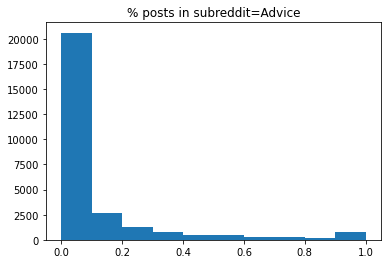

subreddit=Advice
value counts = 
0.0    20600
0.1     2688
0.2     1273
0.3      765
0.4      526
0.5      502
0.6      301
0.7      245
0.8      226
0.9      742
dtype: int64
value cutoff = 0.103; percentiles =
0    20888
1     6980
dtype: int64


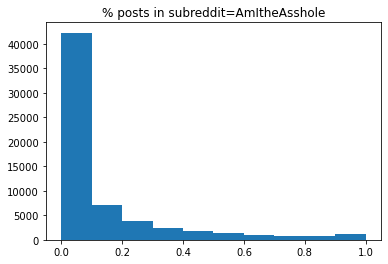

subreddit=AmItheAsshole
value counts = 
0.0    42257
0.1     7190
0.2     3876
0.3     2345
0.4     1752
0.5     1441
0.6      974
0.7      788
0.8      731
0.9     1275
dtype: int64
value cutoff = 0.155; percentiles =
0    46952
1    15677
dtype: int64


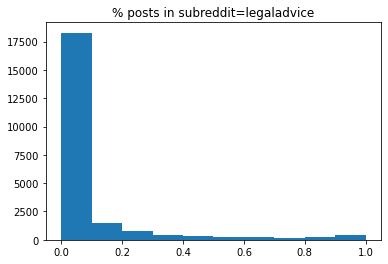

subreddit=legaladvice
value counts = 
0.0    18286
0.1     1441
0.2      733
0.3      432
0.4      293
0.5      269
0.6      206
0.7      202
0.8      210
0.9      440
dtype: int64
value cutoff = 0.052; percentiles =
0    16871
1     5641
dtype: int64


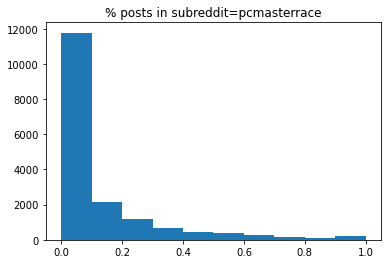

subreddit=pcmasterrace
value counts = 
0.0    11770
0.1     2173
0.2     1199
0.3      672
0.4      471
0.5      394
0.6      266
0.7      180
0.8      127
0.9      210
dtype: int64
value cutoff = 0.150; percentiles =
0    13023
1     4439
dtype: int64


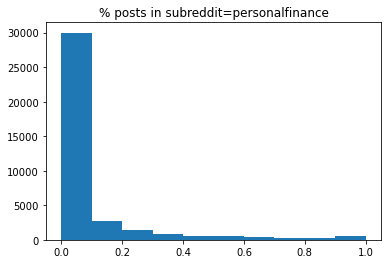

subreddit=personalfinance
value counts = 
0.0    29992
0.1     2769
0.2     1349
0.3      774
0.4      506
0.5      494
0.6      358
0.7      246
0.8      220
0.9      558
dtype: int64
value cutoff = 0.062; percentiles =
0    27947
1     9319
dtype: int64


In [148]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
bins = 10
percentile_cutoff = 75
for subreddit_i, data_i in author_subreddit_counts.groupby('subreddit'):
    plt.hist(data_i.loc[:, 'subreddit_pct'].values)
    plt.title(f'% posts in subreddit={subreddit_i}')
    plt.show()
    # also show counts
    print(f'subreddit={subreddit_i}')
    subreddit_pct_counts = np.histogram(data_i.loc[:, 'subreddit_pct'].values, bins=bins)
    subreddit_pct_counts = pd.Series(subreddit_pct_counts[0], index=subreddit_pct_counts[1][:-1])
    print(f'value counts = \n{subreddit_pct_counts}')
    # compute percentiles
    subreddit_cutoff_pct = np.percentile(data_i.loc[:, 'subreddit_pct'].values, percentile_cutoff)
    subreddit_cutoff_pct_val_counts = pd.Series(np.digitize(data_i.loc[:, 'subreddit_pct'].values, [subreddit_cutoff_pct])).value_counts()
    print(f'value cutoff = {"{:.3f}".format(subreddit_cutoff_pct)}; percentiles =\n{subreddit_cutoff_pct_val_counts}')

We see that the "expert" category is very sparse; can we expand this with nearest-neighbor subreddits?

In [100]:
import re
import os
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime
embed_data_dir = '../../data/reddit_data/author_data/'
subreddit_embed_file_matcher = re.compile('subreddit_embeddings_.*gz')
subreddit_embed_files = list(filter(lambda x: subreddit_embed_file_matcher.match(x) is not None, os.listdir(embed_data_dir)))
subreddit_embed_files = list(map(lambda x: os.path.join(embed_data_dir, x), subreddit_embed_files))
subreddit_nearest_neighbors = []
subreddits_to_query = author_question_data.loc[:, 'question_subreddit'].unique()
top_k = 10
date_fmt = '%Y-%m-%d'
for subreddit_embed_file_i in subreddit_embed_files:
    subreddit_embed_date_i = os.path.basename(subreddit_embed_file_i).split('.')[0].split('_')[-1]
    subreddit_embed_date_i = datetime.strptime(subreddit_embed_date_i, date_fmt)
    subreddit_embed_i = pd.read_csv(subreddit_embed_file_i, sep='\t', compression='gzip', index_col=0)
    for subreddit_j in subreddits_to_query:
        # find nearest neighbors
        if(subreddit_j in subreddit_embed_i.index):
            embed_sim_j = cosine_similarity(subreddit_embed_i.loc[[subreddit_j], :].values,
                                            Y=subreddit_embed_i.values)[0, :]
            embed_sim_j = pd.Series(embed_sim_j, index=subreddit_embed_i.index).sort_values(ascending=False, inplace=False)
            top_k_neighbors_j = embed_sim_j.index.tolist()[1:(top_k+1)]
            subreddit_nearest_neighbors.append([subreddit_j, subreddit_embed_date_i, top_k_neighbors_j])
subreddit_nearest_neighbors = pd.DataFrame(subreddit_nearest_neighbors, columns=['subreddit', 'date', 'neighbors'])

In [101]:
pd.set_option('display.max_colwidth', 500)
subreddit_nearest_neighbors.sort_values('subreddit', inplace=True)
display(subreddit_nearest_neighbors)

,subreddit,date,neighbors
3,Advice,2019-01-01,"[Needafriend, Psychic, needadvice, SuicideWatch, mentalhealth, getdisciplined, Rateme, amiugly, Anxiety, rant]"
8,Advice,2018-01-01,"[dating_advice, socialskills, NoFap, AskDocs, Aquariums, SuicideWatch, Austin, confession, runescape, tipofmytongue]"
17,Advice,2019-07-01,"[answers, Needafriend, MakeNewFriendsHere, lawofattraction, Instagram, NoFap, amiugly, SuicideWatch, medical, ask]"
12,Advice,2018-07-01,"[MakeNewFriendsHere, SuicideWatch, rant, socialskills, Marriage, ApplyingToCollege, amiugly, Anxiety, solotravel, stopdrinking]"
18,AmItheAsshole,2019-07-01,"[PurplePillDebate, survivor, 6thForm, EntitledBitch, kpop, discgolf, pettyrevenge, BravoRealHousewives, notliketheothergirls, blackladies]"
4,AmItheAsshole,2019-01-01,"[IsItBullshit, asktransgender, ftm, bisexual, newzealand, pettyrevenge, LetsNotMeet, melbourne, astrology, britishproblems]"
13,AmItheAsshole,2018-07-01,"[unpopularopinion, TooAfraidToAsk, TrueOffMyChest, offmychest, AMA, rant, AskDocs, TalesFromYourServer, casualiama, changemyview]"
2,legaladvice,2019-01-01,"[Insurance, legaladviceofftopic, bestoflegaladvice, LawSchool, sanfrancisco, Scams, LegalAdviceUK, ProtectAndServe, Divorce, chicago]"
16,legaladvice,2019-07-01,"[legaladvicecanada, Insurance, legaladviceofftopic, LawSchool, lawschooladmissions, polyamory, Landlord, AskHR, Veterans, bestoflegaladvice]"
7,legaladvice,2018-01-01,"[bestoflegaladvice, LawSchool, Aquariums, askcarsales, Accounting, JUSTNOMIL, exmormon, Austin, Seattle, bicycling]"


In [108]:
## filtered data
valid_subreddits = {
    'Advice' : {'needadvice', 'mentalhealth', 'getdisciplined', 'dating_advice', 'socialskills', 'AskDocs', 'tipofmytongue', 'answers', 'ask'},
    'AmItheAsshole' : {'IsItBullshit', 'TooAfraidToAsk', 'AskDocs'},
    'legaladvice' : {'Insurance', 'bestoflegaladvice', 'LawSchool', 'Scams', 'LegalAdviceUK', 'Landlord', 'AskHR'},
    'pcmasterrace' : {'watercooling', 'overclocking', 'bapcsalescanada', 'linuxmasterrace', 'Monitors', 'SuggestALaptop', 'pcgaming', 'buildmeapc'},
    'personalfinance' : {'StudentLoans', 'CreditCards', 'churning', 'tax', 'whatcarshouldIbuy', 'ynab', 'askcarsales', 'Accounting', 'RealEstate', 'financialindependence', 'investing', 'FinancialPlanning', 'smallbusiness'},
}
from functools import reduce
subreddit_nearest_neighbors = subreddit_nearest_neighbors.assign(**{
    'valid_neighbors' : subreddit_nearest_neighbors.apply(lambda x: set(x.loc['neighbors']) & valid_subreddits[x.loc['subreddit']], axis=1)
})
## combine into one set per subreddit
subreddit_combined_neighbors = subreddit_nearest_neighbors.groupby('subreddit').apply(lambda x: set(reduce(lambda a,b: a|b, x.loc[:, 'valid_neighbors'].values))).to_dict()
print(subreddit_combined_neighbors)

{'Advice': {'socialskills', 'mentalhealth', 'needadvice', 'ask', 'answers', 'tipofmytongue', 'getdisciplined', 'AskDocs', 'dating_advice'}, 'AmItheAsshole': {'IsItBullshit', 'AskDocs', 'TooAfraidToAsk'}, 'legaladvice': {'AskHR', 'LawSchool', 'LegalAdviceUK', 'Insurance', 'bestoflegaladvice', 'Scams', 'Landlord'}, 'pcmasterrace': {'SuggestALaptop', 'buildmeapc', 'overclocking', 'watercooling', 'linuxmasterrace', 'pcgaming', 'Monitors', 'bapcsalescanada'}, 'personalfinance': {'smallbusiness', 'askcarsales', 'ynab', 'FinancialPlanning', 'churning', 'RealEstate', 'whatcarshouldIbuy', 'StudentLoans', 'CreditCards', 'investing', 'financialindependence', 'Accounting', 'tax'}}


In [249]:
## write to file for later
clean_subreddit_neighbor_data = pd.DataFrame(pd.Series({'Advice': {'socialskills', 'mentalhealth', 'needadvice', 'ask', 'answers', 'tipofmytongue', 'getdisciplined', 'AskDocs', 'dating_advice'}, 'AmItheAsshole': {'IsItBullshit', 'AskDocs', 'TooAfraidToAsk'}, 'legaladvice': {'AskHR', 'LawSchool', 'LegalAdviceUK', 'Insurance', 'bestoflegaladvice', 'Scams', 'Landlord'}, 'pcmasterrace': {'SuggestALaptop', 'buildmeapc', 'overclocking', 'watercooling', 'linuxmasterrace', 'pcgaming', 'Monitors', 'bapcsalescanada'}, 'personalfinance': {'smallbusiness', 'askcarsales', 'ynab', 'FinancialPlanning', 'churning', 'RealEstate', 'whatcarshouldIbuy', 'StudentLoans', 'CreditCards', 'investing', 'financialindependence', 'Accounting', 'tax'}}))
clean_subreddit_neighbor_data = clean_subreddit_neighbor_data.reset_index(inplace=False).rename(columns={'index' : 'subreddit', 0 : 'neighbors'})
display(clean_subreddit_neighbor_data.head())
clean_subreddit_neighbor_data.to_csv('../../data/reddit_data/author_data/advice_subreddit_neighbors.tsv', sep='\t', index=False)

,subreddit,neighbors
0,Advice,"{getdisciplined, mentalhealth, AskDocs, social..."
1,AmItheAsshole,"{IsItBullshit, TooAfraidToAsk, AskDocs}"
2,legaladvice,"{LawSchool, Insurance, bestoflegaladvice, Lega..."
3,pcmasterrace,"{pcgaming, Monitors, linuxmasterrace, SuggestA..."
4,personalfinance,"{whatcarshouldIbuy, Accounting, askcarsales, c..."


Now that we have the nearest neighbors, let's re-run the "expert" tests.

In [116]:
def get_subreddit_neighbors_pct_per_author_per_date(data, start_date, neighbors):
    data.drop_duplicates('id', inplace=True)
    valid_data = data[data.loc[:, 'date_day_bin'] <= start_date]
    subreddit = data.loc[:, 'question_subreddit'].iloc[0]
    subreddit_neighbors = neighbors[subreddit]
    subreddit_pct = (data.loc[:, 'subreddit'].apply(lambda x: x==subreddit or x in subreddit_neighbors)).sum() / data.shape[0]
    return subreddit_pct

In [117]:
from tqdm import tqdm
author_neighbor_subreddit_counts = []
for subreddit_i, data_i in author_question_data.groupby(['question_subreddit']):
    print(f'**** processing data from subreddit={subreddit_i} ****')
    author_neighbor_subreddit_counts_i = []
    for (author_j, date_j), data_j in tqdm(data_i.groupby(['author', 'question_date_day_bin'])):
        author_neighbor_subreddit_counts_j = get_subreddit_neighbors_pct_per_author_per_date(data_j, data_j.loc[:, 'question_date_day_bin'].iloc[0], subreddit_combined_neighbors)
        author_neighbor_subreddit_counts_i.append([author_j, date_j, author_neighbor_subreddit_counts_j])
    author_neighbor_subreddit_counts_i = pd.DataFrame(author_neighbor_subreddit_counts_i, columns=['author', 'date', 'subreddit_pct'])
    author_neighbor_subreddit_counts_i = author_neighbor_subreddit_counts_i.assign(**{'subreddit' : subreddit_i})
    author_neighbor_subreddit_counts.append(author_neighbor_subreddit_counts_i)
author_neighbor_subreddit_counts = pd.concat(author_neighbor_subreddit_counts, axis=0)

**** processing data from subreddit=Advice ****


100%|██████████| 27868/27868 [01:28<00:00, 314.34it/s]


**** processing data from subreddit=AmItheAsshole ****


100%|██████████| 62629/62629 [03:20<00:00, 312.28it/s]


**** processing data from subreddit=legaladvice ****


100%|██████████| 22512/22512 [01:12<00:00, 310.70it/s]


**** processing data from subreddit=pcmasterrace ****


100%|██████████| 17462/17462 [00:55<00:00, 316.34it/s]


**** processing data from subreddit=personalfinance ****


100%|██████████| 37266/37266 [01:59<00:00, 311.35it/s]


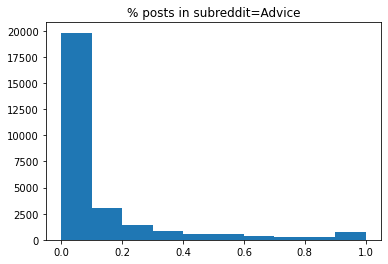

subreddit=Advice
value counts = 
0.0    19818
0.1     3073
0.2     1414
0.3      846
0.4      574
0.5      524
0.6      336
0.7      262
0.8      240
0.9      781
dtype: int64
value cutoff = 0.121; percentiles =
0    20827
1     7041
dtype: int64


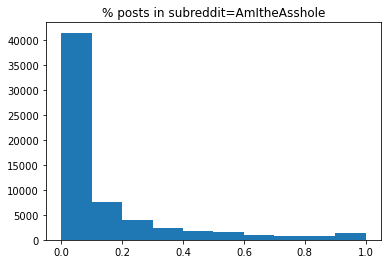

subreddit=AmItheAsshole
value counts = 
0.0    41490
0.1     7612
0.2     4026
0.3     2416
0.4     1782
0.5     1487
0.6      991
0.7      805
0.8      735
0.9     1285
dtype: int64
value cutoff = 0.162; percentiles =
0    46933
1    15696
dtype: int64


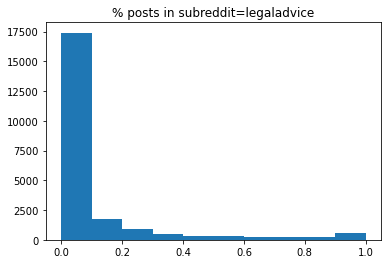

subreddit=legaladvice
value counts = 
0.0    17406
0.1     1781
0.2      918
0.3      502
0.4      334
0.5      333
0.6      232
0.7      219
0.8      250
0.9      537
dtype: int64
value cutoff = 0.081; percentiles =
0    16863
1     5649
dtype: int64


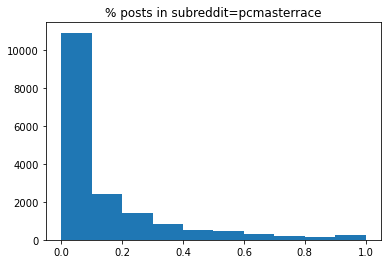

subreddit=pcmasterrace
value counts = 
0.0    10939
0.1     2413
0.2     1402
0.3      814
0.4      542
0.5      446
0.6      303
0.7      216
0.8      145
0.9      242
dtype: int64
value cutoff = 0.184; percentiles =
0    13089
1     4373
dtype: int64


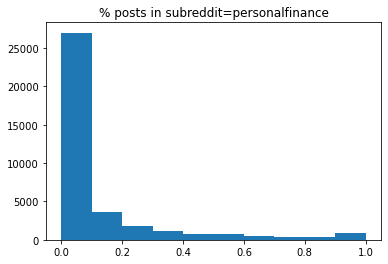

subreddit=personalfinance
value counts = 
0.0    26991
0.1     3634
0.2     1810
0.3     1141
0.4      774
0.5      743
0.6      533
0.7      411
0.8      405
0.9      824
dtype: int64
value cutoff = 0.112; percentiles =
0    27898
1     9368
dtype: int64


In [147]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
bins = 10
percentile_cutoff = 75
for subreddit_i, data_i in author_subreddit_neighbor_counts.groupby('subreddit'):
    plt.hist(data_i.loc[:, 'subreddit_pct'].values, bins=bins)
    plt.title(f'% posts in subreddit={subreddit_i}')
    plt.show()
    # also show counts
    print(f'subreddit={subreddit_i}')
    subreddit_pct_counts = np.histogram(data_i.loc[:, 'subreddit_pct'].values, bins=bins)
    subreddit_pct_counts = pd.Series(subreddit_pct_counts[0], index=subreddit_pct_counts[1][:-1])
    print(f'value counts = \n{subreddit_pct_counts}')
    # compute percentiles
    subreddit_cutoff_pct = np.percentile(data_i.loc[:, 'subreddit_pct'].values, percentile_cutoff)
    subreddit_cutoff_pct_val_counts = pd.Series(np.digitize(data_i.loc[:, 'subreddit_pct'].values, [subreddit_cutoff_pct])).value_counts()
    print(f'value cutoff = {"{:.3f}".format(subreddit_cutoff_pct)}; percentiles =\n{subreddit_cutoff_pct_val_counts}')

OK! We don't see a huge change in the distributions overall, except for maybe a few hundred authors in each subreddit.

## Expand location
We have previously identified an author's location based on whether they disclose their location in prior comments ("I live in ___").

Let's expand this by looking at location-specific subreddits.

In [5]:
author_subreddits = author_data.loc[:, 'subreddit'].unique()
print(len(author_subreddits))

86676


In [7]:
'nyc' in author_subreddits

True

In [9]:
## get top subreddits for location? will save time
subreddit_counts = author_data.loc[:, 'subreddit'].value_counts()
display(subreddit_counts.head(10))

AskReddit              1095276
AmItheAsshole           686828
pcmasterrace            263390
Advice                  210694
politics                209760
personalfinance         204087
relationship_advice     176220
wallstreetbets          154976
legaladvice             139826
unpopularopinion        135142
Name: subreddit, dtype: int64

In [14]:
subreddit_counts[subreddit_counts.index == 'germany']

germany    2344
Name: subreddit, dtype: int64

In [29]:
subreddit_counts[subreddit_counts.index == 'LosAngeles']

LosAngeles    8743
Name: subreddit, dtype: int64

In [26]:
import numpy as np
min_subreddit_count_pct = 95
min_subreddit_count = np.percentile(subreddit_counts, min_subreddit_count_pct)
print(min_subreddit_count)
cutoff_subreddit_counts = subreddit_counts[subreddit_counts >= min_subreddit_count]
print(len(cutoff_subreddit_counts))

466.3000000000029
4334


In [74]:
## naive approach: identify all possible locations in subreddit names by geolocation lol
import geocoder
test_location = 'Michigan'
test_location_estimate = geocoder.osm(test_location)
print(test_location_estimate)

<[OK] Osm - Geocode [Michigan, United States]>


In [76]:
from tqdm import tqdm
# first split camel cases
import re
CAMEL_CASE_MATCHER = re.compile('([a-z])(?=[A-Z])')
def split_subreddit_name(name):
    split_name = name
    # add spaces from the end of word
    for match in reversed(list(CAMEL_CASE_MATCHER.finditer(name))):
        span_start, span_end = match.span()
        split_name = split_name[:span_start+1] + ' ' + split_name[span_end:]
    # also fix underscores
    split_name = split_name.replace('_', ' ')
    return split_name
test_location = 'TestSubName'
print(split_subreddit_name(test_location))

Test Sub Name


In [77]:
clean_subreddit_names = cutoff_subreddit_counts.index.tolist()
clean_subreddit_names = list(map(split_subreddit_name, clean_subreddit_names))
print(clean_subreddit_names[:10])

['Ask Reddit', 'Am Ithe Asshole', 'pcmasterrace', 'Advice', 'politics', 'personalfinance', 'relationship advice', 'wallstreetbets', 'legaladvice', 'unpopularopinion']


In [79]:
# sample reddits with split names
print(list(filter(lambda x: ' ' in x, clean_subreddit_names))[:20])

['Ask Reddit', 'Am Ithe Asshole', 'relationship advice', 'Public Freakout', 'No Stupid Questions', 'Ask Men', 'Reddit Sessions', 'Ask Ouija', 'White People Twitter', 'Roast Me', 'Life Pro Tips', 'Ask Women', 'Too Afraid To Ask', 'True Off My Chest', 'Two XChromosomes', 'Escapefrom Tarkov', 'Idiots In Cars', 'Political Humor', 'Choosing Beggars', 'Destiny The Game']


In [80]:
import geocoder
clean_subreddit_locations = list(map(lambda x: geocoder.osm(x), tqdm(clean_subreddit_names)))

 93%|█████████▎| 4046/4334 [33:46<02:30,  1.92it/s]Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Maladaptive+Dreaming&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=mealtimevideos&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
 93%|█████████▎| 4048/4334 [33:46<01:28,  3.24it/s]Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=tinytower&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
Status co

 94%|█████████▍| 4072/4334 [33:52<02:11,  2.00it/s]Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Wilmington&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Piercing+Advice&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
 94%|█████████▍| 4074/4334 [33:53<02:16,  1.90it/s]Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=serialpodcast&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
Status code Un

Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Konosuba&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
 95%|█████████▍| 4099/4334 [34:06<02:08,  1.83it/s]Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=cpp&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=March+Against+Nazis&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
 95%|█████████▍| 4102/4334 [34:07<01:59,  1.94it/s]Status code Unknown fr

 95%|█████████▌| 4124/4334 [34:18<01:54,  1.83it/s]Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=adhd+anxiety&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=guitarcirclejerk&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
 95%|█████████▌| 4127/4334 [34:20<01:47,  1.93it/s]Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=askcarguys&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
Status code Un

 96%|█████████▌| 4150/4334 [34:31<01:35,  1.93it/s]Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Dermatology&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=misophonia&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
 96%|█████████▌| 4152/4334 [34:32<01:37,  1.86it/s]Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=tuckedinkitties&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
Status code Unkn

Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=NYCbike&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
 96%|█████████▋| 4177/4334 [34:45<01:24,  1.85it/s]Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Batman+Arkham&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=driving&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
 96%|█████████▋| 4179/4334 [34:46<01:24,  1.83it/s]Status code Unknown from 

 97%|█████████▋| 4202/4334 [34:57<01:11,  1.84it/s]Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Trump+Criticizes+Trump&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=kindafunny&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
 97%|█████████▋| 4205/4334 [34:59<01:06,  1.94it/s]Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=laravel&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
Status code U

 98%|█████████▊| 4228/4334 [35:10<00:55,  1.93it/s]Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Fire+Emblem+Three+Houses&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=csgomarketforum&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
 98%|█████████▊| 4230/4334 [35:11<00:55,  1.87it/s]Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=shiba&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
Status c

Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=STD&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
 98%|█████████▊| 4256/4334 [35:24<00:40,  1.93it/s]Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Mariners&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Snus&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
 98%|█████████▊| 4258/4334 [35:25<00:40,  1.88it/s]Status code Unknown from https://nomi

 99%|█████████▉| 4281/4334 [35:37<00:27,  1.93it/s]Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Lineage+OS&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Bushcraft&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
 99%|█████████▉| 4283/4334 [35:38<00:27,  1.86it/s]Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=homesecurity&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
Status code Unknown f

 99%|█████████▉| 4306/4334 [35:43<00:13,  2.06it/s]Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=For+All+Mankind+TV&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=phinvest&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
 99%|█████████▉| 4309/4334 [35:44<00:12,  2.08it/s]Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Detroit+Become+Human&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
Status

100%|█████████▉| 4332/4334 [35:50<00:00, 10.62it/s]Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=mobilerepair&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Reds&format=jsonv2&addressdetails=1&limit=1 (Caused by SSLError(OSError(24, 'Too many open files')))
100%|██████████| 4334/4334 [35:51<00:00,  2.01it/s]


In [109]:
test_name = 'Atlanta'
test_name_location = clean_subreddit_locations[np.where(np.array(clean_subreddit_names)==test_name)[0][0]]
print(test_name_location.geojson)
print(test_name_location.geojson['features'][0]['properties']['accuracy'])

{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'properties': {'accuracy': 0.8008028207926616, 'address': 'Atlanta, Fulton County, Georgia, United States', 'bbox': [-84.551068, 33.647808, -84.28956, 33.886823], 'city': 'Atlanta', 'confidence': 1, 'country': 'United States', 'country_code': 'us', 'county': 'Fulton County', 'icon': 'https://nominatim.openstreetmap.org/ui/mapicons//poi_boundary_administrative.p.20.png', 'importance': 0.8008028207926616, 'lat': 33.7489924, 'lng': -84.3902644, 'ok': True, 'osm_id': 119557, 'osm_type': 'relation', 'place_id': 257814846, 'place_rank': 16, 'quality': 'administrative', 'raw': {'place_id': 257814846, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 119557, 'boundingbox': ['33.647808', '33.886823', '-84.551068', '-84.28956'], 'lat': '33.7489924', 'lon': '-84.3902644', 'display_name': 'Atlanta, Fulton County, Georgia, United States', 'place_rank': 16, 'category': 

In [146]:
import numpy as np
clean_subreddit_location_data = pd.DataFrame(
    [cutoff_subreddit_counts.index.tolist(), clean_subreddit_names], index=['subreddit', 'clean_subreddit']
).transpose()
clean_subreddit_location_data = clean_subreddit_location_data.assign(**{
    'location_data' : list(map(lambda x: x.geojson if x.ok else np.nan, clean_subreddit_locations))
})
clean_subreddit_location_data.dropna(how='any', axis=0, inplace=True)
# clean_subreddit_location_data = clean_subreddit_location_data.assign(**{})
clean_subreddit_location_data = clean_subreddit_location_data.assign(**{
    'accuracy' : clean_subreddit_location_data.loc[:, 'location_data'].apply(lambda x: x['features'][0]['properties']['accuracy'])
})
display(clean_subreddit_location_data.head())
# define cutoff based on min accuracy of test locations
location_accuracy_cutoff = 0.80
high_accuracy_subreddit_location_data = clean_subreddit_location_data[clean_subreddit_location_data.loc[:, 'accuracy']>=location_accuracy_cutoff]
display(high_accuracy_subreddit_location_data.head(20))

,subreddit,clean_subreddit,location_data,accuracy
3,Advice,Advice,"{'type': 'FeatureCollection', 'features': [{'t...",0.111
4,politics,politics,"{'type': 'FeatureCollection', 'features': [{'t...",0.101
10,news,news,"{'type': 'FeatureCollection', 'features': [{'t...",0.300
11,pics,pics,"{'type': 'FeatureCollection', 'features': [{'t...",0.225
12,funny,funny,"{'type': 'FeatureCollection', 'features': [{'t...",0.101


,subreddit,clean_subreddit,location_data,accuracy
147,canada,canada,"{'type': 'FeatureCollection', 'features': [{'t...",0.966126
171,europe,europe,"{'type': 'FeatureCollection', 'features': [{'t...",0.820707
174,de,de,"{'type': 'FeatureCollection', 'features': [{'t...",0.989681
183,australia,australia,"{'type': 'FeatureCollection', 'features': [{'t...",0.952135
243,ireland,ireland,"{'type': 'FeatureCollection', 'features': [{'t...",0.873846
268,nyc,nyc,"{'type': 'FeatureCollection', 'features': [{'t...",0.817577
278,ontario,ontario,"{'type': 'FeatureCollection', 'features': [{'t...",0.835597
280,LosAngeles,Los Angeles,"{'type': 'FeatureCollection', 'features': [{'t...",0.973805
281,chicago,chicago,"{'type': 'FeatureCollection', 'features': [{'t...",0.851530
348,SeattleWA,Seattle WA,"{'type': 'FeatureCollection', 'features': [{'t...",0.882979


What is the distribution of countries?

In [151]:
high_accuracy_subreddit_location_data = high_accuracy_subreddit_location_data.assign(**{
    'country' : high_accuracy_subreddit_location_data.loc[:, 'location_data'].apply(lambda x: x['features'][0]['properties'].get('country_code'))
})
# for all locations that don't have country
country_matches = {
    'europe' : 'eur',
}
high_accuracy_subreddit_location_data = high_accuracy_subreddit_location_data.assign(**{
    'country' : high_accuracy_subreddit_location_data.apply(lambda x: country_matches[x.loc['subreddit']] if x.loc['subreddit'] in country_matches else x.loc['country'], axis=1)
})
## get country regions
country_regions = {
    'us' : 'US'
}
country_regions.update({
    x : 'non_US' for x in high_accuracy_subreddit_location_data.loc[:, 'country'].unique() if x != 'us'
})
high_accuracy_subreddit_location_data = high_accuracy_subreddit_location_data.assign(**{
    'country_region' : high_accuracy_subreddit_location_data.loc[:, 'country'].apply(lambda x: country_regions[x] if x in country_regions else 'UNK')
})
print(high_accuracy_subreddit_location_data.loc[:, 'country'].value_counts().head(20))
print(high_accuracy_subreddit_location_data.loc[:, 'country_region'].value_counts())

us    56
ca     4
au     3
cn     3
de     3
hu     2
nl     2
gb     2
no     2
pl     1
ar     1
in     1
kr     1
fr     1
ch     1
jp     1
pt     1
ro     1
tr     1
dk     1
Name: country, dtype: int64
US        56
non_US    50
Name: country_region, dtype: int64


Obviously very skewed toward US.

What is the location distribution among authors?

In [170]:
# ## join with author data
location_author_data = pd.merge(
    author_data, 
    high_accuracy_subreddit_location_data.loc[:, ['subreddit', 'country', 'country_region']], 
    on='subreddit', how='left',
)
# drop bad authors??
location_author_data.dropna(subset=['author'], inplace=True)
location_author_data = location_author_data[location_author_data.loc[:, 'author'].apply(lambda x: type(x) is str)]
# display(location_author_data.head())
print(location_author_data.loc[:, 'country'].value_counts().head(20))
print(location_author_data.loc[:, 'country_region'].value_counts().head(20))

us     112677
ca      29486
au      18099
de      14321
eur     11181
ie       8247
sg       5023
fr       4700
gb       4166
cn       3829
ro       3760
ph       3751
in       3720
dk       3675
se       3615
it       3229
ar       3215
pt       3094
br       2751
mx       2715
Name: country, dtype: int64
non_US    158276
US        112677
Name: country_region, dtype: int64


This distribution is less bad than I thought!

Let's see the distribution per-author.

In [171]:
from tqdm import tqdm
tqdm.pandas()
author_loc_counts = []
for author_i, data_i in tqdm(location_author_data.groupby('author')):
    author_loc_counts_i = data_i.loc[:, 'country_region'].value_counts().reset_index(name='count').rename(columns={'index' : 'country_region'})
    author_loc_counts_i = author_loc_counts_i.assign(**{'author' : author_i})
    author_loc_counts.append(author_loc_counts_i)
author_loc_counts = pd.concat(author_loc_counts, axis=0)
display(author_loc_counts.head())
# per_author_location_counts = location_author_data.groupby('author').progress_apply(lambda x: x.)
# display(per_author_location_counts.head())

100%|██████████| 188921/188921 [08:16<00:00, 380.48it/s]


,index,country_region,author
0,non_US,1,--Isaac--
0,US,2,--MJL
0,US,1,--NiNjA--
0,non_US,6,--SharkBoy--
0,non_US,8,--_T_T_--


In [202]:
display(author_loc_counts.head())
# # un-melt data => author | US | non-US | all
flat_author_loc_counts = author_loc_counts.pivot(columns='country_region', values='count', index='author').fillna(0., inplace=False).reset_index()
flat_author_loc_counts = flat_author_loc_counts.assign(**{
    'all_locations' : flat_author_loc_counts.loc[:, ['US', 'non_US']].sum(axis=1)
})
display(flat_author_loc_counts.head())

,country_region,count,author
0,non_US,1,--Isaac--
0,US,2,--MJL
0,US,1,--NiNjA--
0,non_US,6,--SharkBoy--
0,non_US,8,--_T_T_--


country_region,author,US,non_US,all_locations
0,--Isaac--,0.0,1.0,1.0
1,--MJL,2.0,0.0,2.0
2,--NiNjA--,1.0,0.0,1.0
3,--SharkBoy--,0.0,6.0,6.0
4,--_T_T_--,0.0,8.0,8.0


In [203]:
min_location_count = 10
print(f'{flat_author_loc_counts[flat_author_loc_counts.loc[:, "all_locations"] >= min_location_count].loc[:, "author"].nunique()} authors who meet country criterion')

7218 authors who meet country criterion


Let's assign locations to these authors, and see how many of these agree/conflict with the previously assigned locations.

In [213]:
def assign_label_by_count(data):
    max_count = data.max()
    if(all(data == max_count)):
        return 'UNK'
    else:
        return data.index[np.where(data == max_count)[0][0]]
country_regions = ['US', 'non_US']
flat_author_loc_counts = flat_author_loc_counts.assign(**{
    'country_region' : flat_author_loc_counts.apply(lambda x: assign_label_by_count(x.loc[country_regions]), axis=1)
})

In [219]:
min_location_count = 10
author_location_subreddit_data = flat_author_loc_counts[flat_author_loc_counts.loc[:, 'all_locations']>=min_location_count].loc[:, ['author', 'country_region']]
display(author_location_subreddit_data.head())

country_region,author,country_region
22,-CoffeeSprocket-,US
25,-DIL-,US
30,-DotDotDot,non_US
33,-Gabria,non_US
34,-Gh0st96-,non_US


In [224]:
author_self_reported_location_data = pd.read_csv('../../data/reddit_data/author_data/author_static_prior_comment_data.gz', sep='\t', compression='gzip', usecols=['author', 'location'])
author_self_reported_location_data = author_self_reported_location_data[author_self_reported_location_data.loc[:, 'location']!='UNK']
# add location region FML
from collections import defaultdict
location_region_lookup = defaultdict(lambda : 'non_US')
location_region_lookup['us'] = 'US'
author_self_reported_location_data = author_self_reported_location_data.assign(**{
    'location_region' : author_self_reported_location_data.loc[:, 'location'].apply(lambda x: location_region_lookup[x])
})
print(f'{author_self_reported_location_data.shape[0]} authors with valid self-reported location')
author_self_reported_location_data.rename(columns={'location_region' : 'self_report_location_region'}, inplace=True)
display(author_self_reported_location_data.head())

14191 authors with valid self-reported location


,author,location,self_report_location_region
7,tboyacending,in,non_US
9,delta390,us,US
40,AgathaAgate,mt,non_US
63,pianoboy1422,us,US
66,HB3234,us,US


In [232]:
author_combined_location_data = pd.merge(author_location_subreddit_data, author_self_reported_location_data.loc[:, ['author', 'self_report_location_region']], on='author', how='inner')
author_combined_location_data = author_combined_location_data[author_combined_location_data.loc[:, 'country_region']!='UNK']
print(f'{author_combined_location_data.shape[0]} authors with both subreddit and self-reported locations')
display(author_combined_location_data.head())

710 authors with both subreddit and self-reported locations


,author,country_region,self_report_location_region
0,-CoffeeSprocket-,US,US
1,-Jim-Lahey,US,US
2,-Johnny-,US,non_US
3,123cats-,US,US
4,13159daysold,non_US,non_US


In [237]:
location_agreement = (author_combined_location_data.loc[:, 'country_region']==author_combined_location_data.loc[:, 'self_report_location_region']).sum()
print(f'{location_agreement / author_combined_location_data.shape[0]*100}% agreement in locations')
## better than random?
from scipy.stats import chi2_contingency
location_count_table = pd.concat([
    author_combined_location_data.loc[:, 'country_region'].value_counts(),
    author_combined_location_data.loc[:, 'self_report_location_region'].value_counts(),
], axis=1)
chi_2, p_val, _, _ = chi2_contingency(location_count_table)
print(f'chi2={chi_2} (p={p_val})')
from sklearn.metrics import cohen_kappa_score
agreement_stat = cohen_kappa_score(author_combined_location_data.loc[:, 'country_region'].values, author_combined_location_data.loc[:, 'self_report_location_region'].values)
print(f'{agreement_stat} agreement')

87.74647887323944% agreement in locations
chi2=0.40927841860967834 (p=0.5223359789283297)
0.7528112369442554 agreement


OK! So the proportions of US and non-US are roughly the same and we have high agreement.

We will therefore use the location subreddit counts to boost our location coverage.

How much of an increase do we get by including the subreddit-location data?

In [240]:
self_report_location_authors = author_self_reported_location_data.loc[:, 'author'].unique()
extra_location_authors = set(author_location_subreddit_data.loc[:, 'author'].unique()) - set(self_report_location_authors)
print(f'{len(self_report_location_authors)} authors with self-reported location')
print(f'{len(extra_location_authors)} authors with only subreddit-reported location')

14191 authors with self-reported location
6506 authors with only subreddit-reported location


Great! We can increase the sample by almost 50%.